In [1]:
#This should be the complete set of data needed to graph the orbits
import orekit
vm = orekit.initVM()
from org.orekit.data import DataProvidersManager, ZipJarCrawler
from org.orekit.frames import FramesFactory
from org.orekit.bodies import OneAxisEllipsoid
from org.orekit.time import TimeScalesFactory, AbsoluteDate
from org.orekit.orbits import KeplerianOrbit, PositionAngle
from org.orekit.utils import Constants, IERSConventions
from org.orekit.propagation.analytical import EcksteinHechlerPropagator

from orekit.pyhelpers import setup_orekit_curdir

from math import radians
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
from netCDF4 import Dataset
import hvplot.xarray
import hvplot.pandas
# from mpl_toolkits.basemap import Basemap

setup_orekit_curdir()

## Some Constants
ae = Constants.WGS84_EARTH_EQUATORIAL_RADIUS
mu = Constants.WGS84_EARTH_MU
utc = TimeScalesFactory.getUTC()

## Osculating orbit
#Initial orbit parameters
ra = 800 * 1000         # Apogee
rp = 700 * 1000         # Perigee
i = radians(98.55)      # Inclination
omega = radians(90.0)   # Perigee argument
raan = radians(5.1917)  # Right ascension of ascending node
lv = radians(359.93)    # True anomaly

epochDate = AbsoluteDate(2012, 1, 26, 16, 0, 00.000, utc)

a = (rp + ra + 2 * ae) / 2.0    
e = 1.0 - (rp + ae) / a

## Inertial frame where the satellite is defined
inertialFrame = FramesFactory.getEME2000()

## Orbit construction as Keplerian
initialkeplerOrbit = KeplerianOrbit(a, e, i, omega, raan, lv,
                              PositionAngle.TRUE,
                              inertialFrame, epochDate, mu)

## Set up Propagator for reference orbit
eck_prop = EcksteinHechlerPropagator(initialkeplerOrbit,
                                    Constants.WGS84_EARTH_EQUATORIAL_RADIUS,
                                    Constants.WGS84_EARTH_MU,
                                    Constants.WGS84_EARTH_C20,
                                    0.0,
                                    0.0,
                                    0.0,
                                    0.0)

startDate = AbsoluteDate(2012, 1, 26, 11, 0, 00.000, utc)

# Overall duration in seconds for extrapolation
duration = 24 * 60 * 60
step_time = 10

# Time array in orekit AbsoluteDate format
t = [startDate.shiftedBy(float(dt)) \
        for dt in np.arange(0, duration, step_time)]

pv = [eck_prop.propagate(tt).getPVCoordinates() for tt in t]
p = [tpv.getPosition() for tpv in pv]

ITRF = FramesFactory.getITRF(IERSConventions.IERS_2010, True)
earth = OneAxisEllipsoid(Constants.WGS84_EARTH_EQUATORIAL_RADIUS, 
                         Constants.WGS84_EARTH_FLATTENING, 
                         ITRF)
        
subpoint = [earth.transform(tp, inertialFrame, tt)  for tt, tp in zip(t,p)]

lat = np.degrees([gp.getLatitude()  for gp in subpoint])
lon = np.degrees([gp.getLongitude() for gp in subpoint])

df  = pd.DataFrame(lat,lon)
# df.hvplot.scatter(color='orange',size=10)

In [33]:
# graph for the netCDF file 

ds = xr.open_dataset('gsm.20130316_010000.nc')
ds  # Will show you what variables and shape they are in the file

data1 = Dataset('gsm.20130316_010000.nc')
data1.variables.keys()

height  = ds.wam_height_levels #.isel(x03 = 1)      
# height.hvplot.quadmesh(x="x01",y="x02")
# height.hvplot()

In [20]:
df.hvplot.scatter(color='orange',size=10)
height.hvplot.quadmesh(x="x01",y="x02")



:QuadMesh   [x01,x02]   (wam_height_levels)

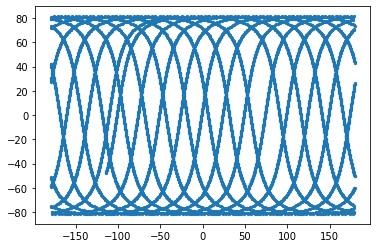

In [28]:
plt.scatter(lon,lat,s=5)

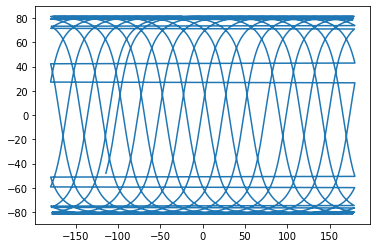

In [36]:
Fig, ax = plt.subplots()
# ax.pcolormesh(height['x01'], height['x02'], height['x03'])
ax.plot(lon, lat)
